In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sub_act import sub_input, sub_process
from utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
vol_file = Path('../Voltron_data/Voltron_Log_DRN_Exp.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
# using Path to handle switches filesystems
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system

vol_file = Path('depreciated/analysis_opto_based_on_swim_pattern.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

### High-low gain activity in swim bouts -- spikes

In [3]:
k_win = 60
k_ = boxcarKernel(sigma=k_win)
ave_low_list = []
ave_high_list = []
row_ = 0
for __, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    if 'Optovin' not in row['task']:
        continue    
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    if not os.path.exists(dat_dir/'Voltr_spikes.npz'):
        continue
    dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
    num_cell = spk.shape[0]
    # spk with padding zeros for the first 2 seconds
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')

    _ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    visu = _['visu']
    p_swim = np.sqrt(r_swim**2+l_swim**2)
    
    task_period = frame_stimParams[2,swim_starts] # 1, low; 2 high
    task_period = task_period + frame_stimParams[3,swim_starts]*2 -2 # 
    opto_ = frame_stimParams[5]
    opto_t = np.where(opto_)[0]
    for n_ in range(len(swim_starts)):
        if (swim_starts[n_]>opto_t).sum() == 0:
            continue
        if swim_starts[n_] - opto_t[swim_starts[n_]>opto_t][-1]<10*300:
            task_period[n_] = task_period[n_] + 2
        if (swim_starts[n_]<opto_t).sum() == 0:
            continue
        if swim_starts[n_] - opto_t[swim_starts[n_]<opto_t][0]>-300:
            task_period[n_] = 0
            
    count_, _ = np.histogram(task_period, bins=range(8))
    if count_[1]<100:
        continue
    
    win_size = 3
    first_swim_bout_index = [np.where((task_period[:-1]!=5) & (task_period[1:]==5))[0]+1]
    first_swim_bout_index.append(np.where((task_period[:-1]!=6) & (task_period[1:]==6))[0]+1)
    
    if win_size > 1:
        first_swim_bout_index[0] = np.concatenate([first_swim_bout_index[0]+_ for _ in range(win_size)])
        first_swim_bout_index[0] = first_swim_bout_index[0][first_swim_bout_index[0]<len(task_period)]
        first_swim_bout_index[1] = np.concatenate([first_swim_bout_index[1]+_ for _ in range(win_size)])
        first_swim_bout_index[1] = first_swim_bout_index[1][first_swim_bout_index[1]<len(task_period)]
    
    for clip_index in first_swim_bout_index:
        task_period[clip_index] = 0
    
    for n_cell in range(spk.shape[0]):
        if spk[n_cell].mean()*300 < 0:
            continue
        spk_list = np.zeros((r_swim.shape[0], k_win*2+400))
        remove_list = np.zeros(r_swim.shape[0]).astype('bool')
        for n, n_swim in enumerate(swim_starts):
            try:
                spk_list[n, :] = spk[n_cell, n_swim-k_win-100:n_swim+300+k_win]
            except:
                remove_list[n]=True
        spk_list = spk_list[~remove_list, :]
        task_period_ = task_period[~remove_list]
        _ = []
        for n_ in range(6):
            ave_ = spk_list[task_period_==n_+1].mean(axis=0)*300
            _.append(smooth(ave_, k_))
        for n_ in range(2):
            ave_ = spk_list[first_swim_bout_index[n_]].mean(axis=0)*300
            _.append(smooth(ave_, k_))
        ave_low_list.append(_[0::2])
        ave_high_list.append(_[1::2])

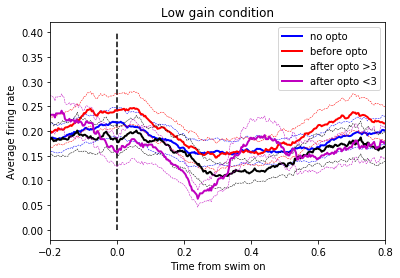

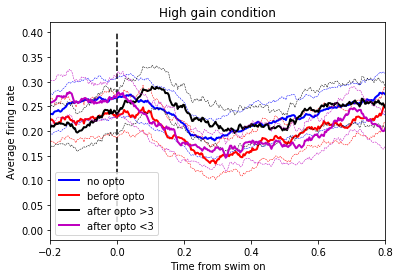

In [4]:
ave_low_list_ = np.array(ave_low_list)
ave_high_list_ = np.array(ave_high_list)

act_list = ave_low_list_
ave_act = np.array(act_list).mean(axis=0)
sem_act = np.array(act_list).std(axis=0)/np.sqrt(len(act_list))
line_spec = ['b', 'r', 'k', 'm']
labels = ['no opto', 'before opto', f'after opto >{win_size}', f'after opto <{win_size}']
for n_ in range(4): # [0, 3]:#
    plt.plot(np.arange(k_win*2+400)/300 - (100+k_win//2)/300, ave_act[n_], f'-{line_spec[n_]}', lw=2, label=labels[n_])
    plt.plot(np.arange(k_win*2+400)/300 - (100+k_win//2)/300, ave_act[n_]+sem_act[n_], f'--{line_spec[n_]}', lw=0.5)
    plt.plot(np.arange(k_win*2+400)/300 - (100+k_win//2)/300, ave_act[n_]-sem_act[n_], f'--{line_spec[n_]}', lw=0.5)
plt.vlines([0], [0], [0.4], linestyles='--', color='k')
plt.xlim([-0.2, 0.8])
# plt.ylim([0, 0.5])
plt.title('Low gain condition')
plt.xlabel('Time from swim on')
plt.ylabel('Average firing rate')
plt.legend()
plt.show()

act_list = ave_high_list_
ave_act = np.array(act_list).mean(axis=0)
sem_act = np.array(act_list).std(axis=0)/np.sqrt(len(act_list))
line_spec = ['b', 'r', 'k', 'm']
labels = ['no opto', 'before opto', f'after opto >{win_size}', f'after opto <{win_size}']
for n_ in range(4):# [0, 3]:
    plt.plot(np.arange(k_win*2+400)/300 - (100+k_win//2)/300, ave_act[n_], f'-{line_spec[n_]}', lw=2, label=labels[n_])
    plt.plot(np.arange(k_win*2+400)/300 - (100+k_win//2)/300, ave_act[n_]+sem_act[n_], f'--{line_spec[n_]}', lw=0.5)
    plt.plot(np.arange(k_win*2+400)/300 - (100+k_win//2)/300, ave_act[n_]-sem_act[n_], f'--{line_spec[n_]}', lw=0.5)
plt.vlines([0], [0], [0.4], linestyles='--', color='k')
plt.xlim([-0.2, 0.8])
# plt.ylim([0, 0.5])
plt.title('High gain condition')
plt.xlabel('Time from swim on')
plt.ylabel('Average firing rate')
plt.legend()
plt.show()

### Clustering

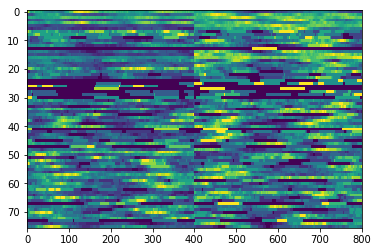

In [5]:
act_ = np.concatenate([ave_low_list_[:, 0, k_win:-k_win], ave_high_list_[:, 0, k_win:-k_win]], axis = -1)
act_ = act_/act_.max(axis=-1, keepdims=True)
plt.imshow(act_, aspect='auto')

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
pca.fit(act_)
act_pca = pca.inverse_transform(pca.transform(act_))

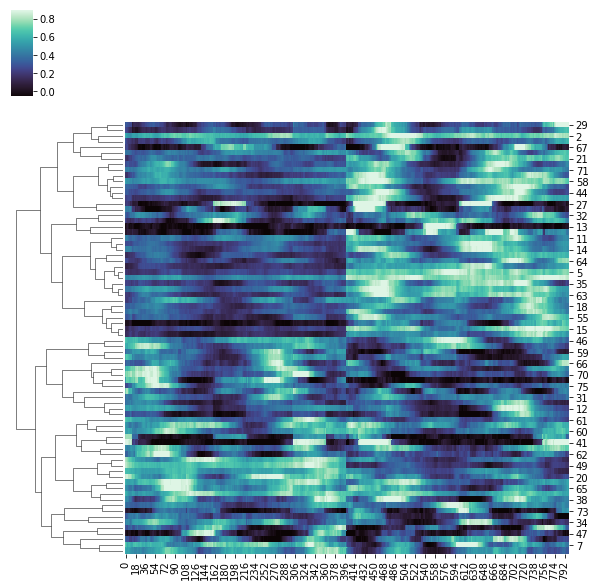

In [7]:
cluster_ = sns.clustermap(act_pca, method="complete", metric="correlation", cmap="mako", robust=True, col_cluster=False)

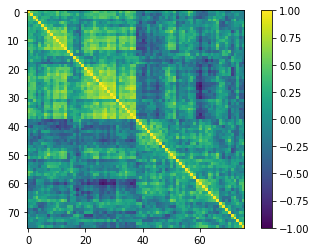

In [8]:
plt.imshow(np.corrcoef(act_[cluster_.dendrogram_row.reordered_ind,:]), vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [9]:
from scipy.cluster.hierarchy import cut_tree, linkage
link_ = linkage(act_pca, method='complete', metric='correlation')
num_cluster = 2
cut_tree_ = cut_tree(link_, n_clusters=num_cluster)

In [10]:
# for n_ in range(num_cluster):
# #     plt.imshow(np.corrcoef(act_[cut_tree_.ravel()==n_,:]), vmin=-1, vmax=1)
#     plt.imshow(act_[cut_tree_.ravel()==n_,:], vmin=0, vmax=1, aspect='auto')
#     plt.colorbar()
#     plt.show()

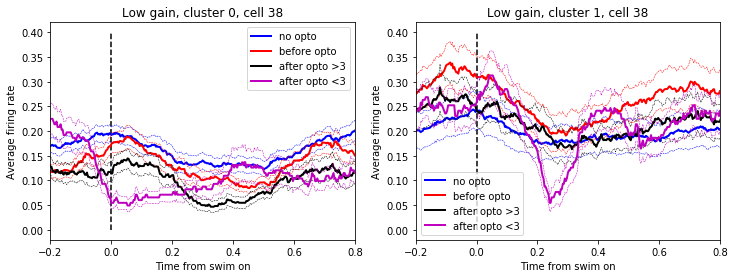

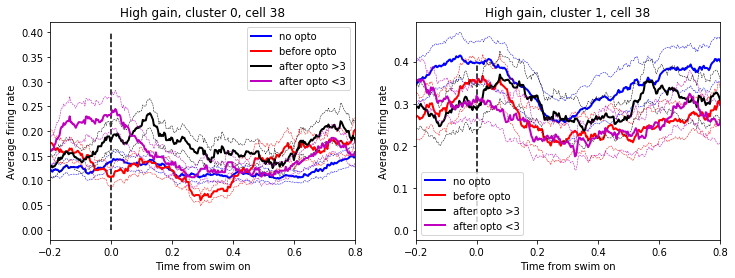

In [11]:
ave_low_list_ = np.array(ave_low_list)
ave_high_list_ = np.array(ave_high_list)


line_spec = ['b', 'r', 'k', 'm']
labels = ['no opto', 'before opto', f'after opto >{win_size}', f'after opto <{win_size}']
act_list = ave_low_list_
fig, ax = plt.subplots(1, num_cluster, figsize=(num_cluster*6, 4))
for c_ in range(num_cluster):
    cell_num = (cut_tree_.ravel()==c_).sum()
    ave_act = np.array(act_list[cut_tree_.ravel()==c_]).mean(axis=0)
    sem_act = np.array(act_list[cut_tree_.ravel()==c_]).std(axis=0)/np.sqrt(len(act_list))
    for n_ in range(4): # [0, 3]:#
        ax[c_].plot(np.arange(k_win*2+400)/300 - (100+k_win//2)/300, ave_act[n_], f'-{line_spec[n_]}', lw=2, label=labels[n_])
        ax[c_].plot(np.arange(k_win*2+400)/300 - (100+k_win//2)/300, ave_act[n_]+sem_act[n_], f'--{line_spec[n_]}', lw=0.5)
        ax[c_].plot(np.arange(k_win*2+400)/300 - (100+k_win//2)/300, ave_act[n_]-sem_act[n_], f'--{line_spec[n_]}', lw=0.5)
    ax[c_].vlines([0], [0], [0.4], linestyles='--', color='k')
    ax[c_].set_xlim([-0.2, 0.8])
    ax[c_].set_title(f'Low gain, cluster {c_}, cell {cell_num}')
    ax[c_].set_xlabel('Time from swim on')
    ax[c_].set_ylabel('Average firing rate')
    ax[c_].legend()
plt.show()

act_list = ave_high_list_
fig, ax = plt.subplots(1, num_cluster, figsize=(num_cluster*6, 4))
for c_ in range(num_cluster):
    cell_num = (cut_tree_.ravel()==c_).sum()
    ave_act = np.array(act_list[cut_tree_.ravel()==c_]).mean(axis=0)
    sem_act = np.array(act_list[cut_tree_.ravel()==c_]).std(axis=0)/np.sqrt(len(act_list))
    for n_ in range(4): # [0, 3]:#
        ax[c_].plot(np.arange(k_win*2+400)/300 - (100+k_win//2)/300, ave_act[n_], f'-{line_spec[n_]}', lw=2, label=labels[n_])
        ax[c_].plot(np.arange(k_win*2+400)/300 - (100+k_win//2)/300, ave_act[n_]+sem_act[n_], f'--{line_spec[n_]}', lw=0.5)
        ax[c_].plot(np.arange(k_win*2+400)/300 - (100+k_win//2)/300, ave_act[n_]-sem_act[n_], f'--{line_spec[n_]}', lw=0.5)
    ax[c_].vlines([0], [0], [0.4], linestyles='--', color='k')
    ax[c_].set_xlim([-0.2, 0.8])
    ax[c_].set_title(f'High gain, cluster {c_}, cell {cell_num}')
    ax[c_].set_xlabel('Time from swim on')
    ax[c_].set_ylabel('Average firing rate')
    ax[c_].legend()
plt.show()

### Around UV pulses
* average activity (psth)
* raster plot
* average activity around (UV time)

In [12]:
# k_ = boxcarKernel(sigma=100)
# ave_low_list = []
# ave_high_list = []
# row_id = -1
# is_plot = True
# for _, row in dat_xls_file.iterrows():
#     folder = row['folder']
#     fish = row['fish']
#     row_id = row_id+1
#     if 'Optovin' not in row['task']:
#         continue
#     dat_dir = dir_folder/f'{folder}/{fish}/Data/'
#     swim_dir = dir_folder/f'{folder}/{fish}/swim/'
#     dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
#     dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
#     spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
#     num_cell = spk.shape[0]
#     # spk with padding zeros for the first 2 seconds
#     spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
#     frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
#     frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')
#     gain_ = frame_stimParams[2]
#     opto_ = frame_stimParams[5]
#     opto_t = np.where(opto_)[0]
#     win_size = 4
#     for win_ in range(-win_size, win_size+1):
#         spk[:, opto_t+win_]=0
#     opto_epoch = frame_stimParams[3]
#     trial_ = frame_stimParams[4]
#     if spk.shape[-1]>len(trial_):
#         trial_ = np.concatenate([trial_, np.zeros(spk.shape[-1]-len(trial_))])
#     else:
#         trial_ = trial_[:spk.shape[-1]]
#     num_trial = trial_.max().astype('int')-1
    
#     for n_cell in range(spk.shape[0]):
#         print([row_id, n_cell, spk[n_cell].mean()*300])
#         if spk[n_cell].mean()*300 < 0.2:
#             continue
#         spk_list = []
#         for ntrial in range(num_trial):
#             spk_list.append(spk[n_cell, trial_==ntrial+1])
#         trial_len = min([_.shape for _ in spk_list])[0]
#         spk_list_ = np.vstack([_[:trial_len] for _ in spk_list])
#         k_ = boxcarKernel(sigma=100)
#         ave_ = spk_list_.mean(axis=0)
#         epoch_len = trial_len//4
#         labels = ['low', 'high', 'low+optv', 'high+optv']
#         if not is_plot:
#             continue
#         for n_epoch in range(4):
#             ave_smooth = smooth(ave_[n_epoch*epoch_len:(n_epoch+1)*epoch_len], k_)*300
#             plt.plot(np.arange(epoch_len)/300, ave_smooth+4*n_epoch, label=labels[n_epoch])
#         plt.vlines([10], [0], [16], linestyles='--', color='k')
#         plt.xlim([0, epoch_len/300])
#         plt.ylim([0, 16])
#         sns.despine()
#         plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3)
#         plt.show()

In [13]:
# # raster plot
# from utils import plt_raster
# ave_low_list = []
# ave_high_list = []
# for _, row in dat_xls_file.iterrows():
#     folder = row['folder']
#     fish = row['fish']
#     row_id = row_id+1
#     if 'Optovin' not in row['task']:
#         continue
#     dat_dir = dir_folder/f'{folder}/{fish}/Data/'
#     swim_dir = dir_folder/f'{folder}/{fish}/swim/'
#     dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
#     dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
#     spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
#     num_cell = spk.shape[0]
#     spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
#     frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
#     frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')
#     gain_ = frame_stimParams[2]
#     opto_ = frame_stimParams[5]
#     opto_t = np.where(opto_)[0]
#     win_size = 10
#     for win_ in range(-win_size, win_size+1):
#         spk[:, opto_t+win_]=0
#     opto_epoch = frame_stimParams[3]
#     trial_ = frame_stimParams[4]
#     if spk.shape[-1]>len(trial_):
#         trial_ = np.concatenate([trial_, np.zeros(spk.shape[-1]-len(trial_))])
#     else:
#         trial_ = trial_[:spk.shape[-1]]
#     num_trial = trial_.max().astype('int')-1
#     win_len = 1200
#     for n_cell in range(spk.shape[0]):
#         print([row_id, n_cell, spk[n_cell].mean()*300])
#         spk_list = []
#         for ntrial in range(num_trial):
#             spk_list.append(spk[n_cell, trial_==ntrial+1])
#         trial_len = min([_.shape for _ in spk_list])[0]
#         spk_list_ = np.vstack([_[:trial_len] for _ in spk_list])
#         k_ = boxcarKernel(sigma=100)
#         ave_ = spk_list_.mean(axis=0)
#         epoch_len = trial_len//4
#         if not is_plot:
#             continue
#         c = ['k', 'r', 'b', 'm'] #'no opto low', 'no opto high'
#         for n_epoch in range(4):
#             plt_raster(spk_list_[:, n_epoch*epoch_len+epoch_len//2-win_len:n_epoch*epoch_len+epoch_len//2+win_len], c=c[n_epoch], t_shift=win_len)
#         plt.vlines([0], [0], [16], linestyles='--', color='k')
#         plt.xlim([-win_len/300, win_len/300])
#         plt.ylim([0, 8])
#         sns.despine()
#         plt.show()

In [14]:
# raster plot
from scipy.stats import wilcoxon, mannwhitneyu
fr_list = []
sig_list = []
from utils import plt_raster
for _, row in dat_xls_file.iterrows():
    folder = row['folder']
    fish = row['fish']
    if 'Optovin' not in row['task']:
        continue
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
    num_cell = spk.shape[0]
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')
    gain_ = frame_stimParams[2]
    opto_ = frame_stimParams[5]
    opto_t = np.where(opto_)[0]
    win_size = 10
    for win_ in range(-win_size, win_size+1):
        spk[:, opto_t+win_]=0
    opto_epoch = frame_stimParams[3]
    trial_ = frame_stimParams[4]
    if spk.shape[-1]>len(trial_):
        trial_ = np.concatenate([trial_, np.zeros(spk.shape[-1]-len(trial_))])
    else:
        trial_ = trial_[:spk.shape[-1]]
    num_trial = trial_.max().astype('int')-1
    win_len = 1200
    for n_cell in range(spk.shape[0]):
        if spk[n_cell].mean()*300 < 0:
            continue
        spk_list = []
        for ntrial in range(num_trial):
            spk_list.append(spk[n_cell, trial_==ntrial+1])
        trial_len = min([_.shape for _ in spk_list])[0]
        spk_list_ = np.vstack([_[:trial_len] for _ in spk_list])
        k_ = boxcarKernel(sigma=100)
        epoch_len = trial_len//4
        r_list = []
        sig_ = []
        for n_epoch in range(4):
            r_list.append(spk_list_[:, n_epoch*epoch_len+epoch_len//2-win_len:n_epoch*epoch_len+epoch_len//2].mean()*300)
            r_list.append(spk_list_[:, n_epoch*epoch_len+epoch_len//2:n_epoch*epoch_len+epoch_len//2+win_len].mean()*300)
            # _, p = wilcoxon(spk_list_[:, n_epoch*epoch_len+epoch_len//2-win_len:n_epoch*epoch_len+epoch_len//2].mean(axis=-1)-spk_list_[:, n_epoch*epoch_len+epoch_len//2:n_epoch*epoch_len+epoch_len//2+win_len].mean(axis=-1))
            if spk_list_[:, n_epoch*epoch_len+epoch_len//2:n_epoch*epoch_len+epoch_len//2+win_len].mean() == 0 and spk_list_[:, n_epoch*epoch_len+epoch_len//2:n_epoch*epoch_len+epoch_len//2+win_len].mean()==0:
                p = 1.0
            else:
                _, p = mannwhitneyu(spk_list_[:, n_epoch*epoch_len+epoch_len//2-win_len:n_epoch*epoch_len+epoch_len//2].mean(axis=-1), spk_list_[:, n_epoch*epoch_len+epoch_len//2:n_epoch*epoch_len+epoch_len//2+win_len].mean(axis=-1))
            sig_.append(p)
        fr_list.append(r_list)
        sig_list.append(sig_)

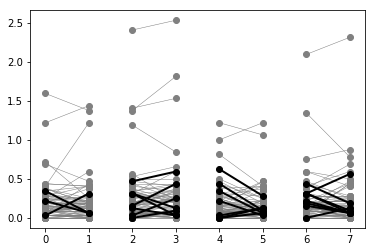

number of neuron decreases activity
2
3
4
6
number of neuron increases activity
1
4
3
2


In [15]:
fr_list_ = np.array(fr_list)
sig_list_ = np.array(sig_list)
sig_thres = 0.1
for n_epoch in range(4):
    sig_ind = sig_list_[:, n_epoch]<sig_thres
    plt.plot(np.arange(n_epoch*2, n_epoch*2+2), (fr_list_[~sig_ind,n_epoch*2:n_epoch*2+2]).T, '-o', color='0.5', lw=0.5) # /(fr_list_[:,n_epoch*2][:, np.newaxis]+0.001)
    plt.plot(np.arange(n_epoch*2, n_epoch*2+2), (fr_list_[sig_ind,n_epoch*2:n_epoch*2+2]).T, '-ok', lw=2) # /(fr_list_[:,n_epoch*2][:, np.newaxis]+0.001)
# plt.ylim([0, 0.8])
plt.show()

print('number of neuron decreases activity')
for n_epoch in range(4):
    print(((fr_list_[:,n_epoch*2]>fr_list_[:,n_epoch*2+1]) & (sig_list_[:, n_epoch]<sig_thres)).sum())

print('number of neuron increases activity')
for n_epoch in range(4):
    print(((fr_list_[:,n_epoch*2]<fr_list_[:,n_epoch*2+1]) & (sig_list_[:, n_epoch]<sig_thres)).sum())